# U-Net for Road Segmentation

## Required Folder Structure

The working folder contains the following subfolders:
* `training` Contains:
    * `groundtruth` Contains the groudtruth images (format: `satImage_xxx.png`)
    * `images` Contains the images to segment (format: `satImage_xxx.png`)
* `predictions_submission` Will contain the images predicted to create a submission
* `test_set_images` Contains the test images used to create a submission (format: `test_x.png` or `test_xx.png`)

This folder also contains 2 files:
* `road_segmentation_model.h5` Saved version the model. Allows to save the weights of the previous training that was done
* `smooth_tiled_prediction.py` Present in the GitHub repo.

In another folder we will store the autogenerated images. This folder should be called `augmented_set`.
In this folder there must be 2 subfolders:
* `groundtruth` contains autogenerated groundtruths
* `images` contains autogenerates images

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!nvidia-smi

Thu Dec 19 12:30:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    58W / 149W |    147MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -U tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


## Pipeline

### Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import argparse
import datetime
import os
import random
import re
import sys

from itertools import chain
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import backend as K
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
import sklearn.metrics
PATH_TO_SMOOTH_TILED_PREDICT = '/content/drive/My Drive/ML_road_image'
sys.path.insert(1, PATH_TO_SMOOTH_TILED_PREDICT)
exists = os.path.isfile("/content/drive/My Drive/ML_road_image/smooth_tiled_predictions.py")
if not exists:
  print("[INFO]: Downloading smooth tile prediction")
  !wget --output-document=drive/My\ Drive/ML_road_image/smooth_tiled_predictions.py https://raw.githubusercontent.com/Vooban/Smoothly-Blend-Image-Patches/master/smooth_tiled_predictions.py
from smooth_tiled_predictions import predict_img_with_smooth_windowing
from time import strftime
from tqdm import tqdm

Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0'

In [4]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Number of GPUs Available:  1


### Constant Definitions

#### Non-Tweakable

In [0]:
# Image definition
IMG_WIDTH    = 400
IMG_HEIGHT   = 400
IMG_CHANNELS = 3
PIXEL_DEPTH  = 255

# Folder definitions
IMAGE_DATA_PATH           = '/content/drive/My Drive/ML_road_image/images/'
MASK_DATA_PATH            = '/content/drive/My Drive/ML_road_image/groundtruth/'
MODEL_SAVE_LOCATION       = '/content/drive/My Drive/ML_road_image/road_segmentation_model_Unet++_100.h5'
SUBMISSION_DATA_DIR       = '/content/drive/My Drive/ML_road_image/test_set_images/'
PREDICTION_SUBMISSION_DIR = '/content/drive/My Drive/ML_road_image/predictions_submission/'
COMPRESSED_IMG_LOCATION = {'100' : '/content/drive/My Drive/ML_road_image/100img.npz',
                           '1500': '/content/drive/My Drive/ML_road_image/1500img.npz',
                           '10000': '/content/drive/My Drive/ML_road_image/10000img.npz'}
IMAGES_FILENAMES = os.listdir(IMAGE_DATA_PATH)

# Image generation
OUTPUT_DATA_IMAGE_PATH = '/content/drive/My Drive/ML_road_image_generated/'

# Seeding
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed = SEED
#tf.random.set_random_seed(SEED) # TensorFlow version 1
tf.random.set_seed(SEED) # TensorFlow version 2

# Checkpoints
checkpoint_path = 'checkpoints/cp.ckpt'
checkpoint_dir  = os.path.dirname(checkpoint_path)

#### Tweakable

In [0]:
# Image generation
GENERATE_NEW_IMG   = False
USE_GENERATED_IMG  = False
IMG_TO_GEN_PER_IMG = 100

# Load existing model
USE_SAVED_MODEL = True

# F1-score estimation
NUMBER_OF_IMG_TO_TEST = 20

# Predictions
RUN_PREDICTIONS_ON_TEST_IMAGES = True

# Rapid import from saved numpy array
USE_COMPRESS_IMG = True
COMPRESSED_IMG_TO_USE = '1500'

# Verbose
VERBOSE = True

### Image Generation

In [0]:
if GENERATE_NEW_IMG:
    # load the input image, convert it to a NumPy array, and then
    # reshape it to have an extra dimension
    for img in tqdm(IMAGES_FILENAMES):
        image = load_img(IMAGE_DATA_PATH+img)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        truth = load_img(MASK_DATA_PATH+img)
        truth = img_to_array(truth)
        truth = np.expand_dims(truth, axis=0)
        # construct the image generator for data augmentation then
        # initialize the total number of images generated thus far
        aug = ImageDataGenerator(rotation_range=360,
                  zoom_range=0.3,
                  brightness_range=[0.7,1],
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  vertical_flip=True,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="reflect")
        total = 0

        # construct the actual Python generator
        imageGen = aug.flow(image, y=truth, batch_size=1, save_to_dir=OUTPUT_DATA_IMAGE_PATH + "images",
          save_prefix=img.split(".")[0], save_format="png", seed = SEED )
        truthGen = aug.flow(truth, y=truth, batch_size=1, save_to_dir=OUTPUT_DATA_IMAGE_PATH + "groundtruth",
          save_prefix=img.split(".")[0], save_format="png", seed = SEED )
        # loop over examples from our image data augmentation generator
        for image in imageGen:
            # increment our counter
            total += 1

            # if we have reached the specified number of examples, break
            # from the loop
            if total == IMG_TO_GEN_PER_IMG:
                break

        total = 0
        for image in truthGen:
            # increment our counter
            total += 1

            # if we have reached the specified number of examples, break
            # from the loop
            if total == IMG_TO_GEN_PER_IMG:
                break

if(USE_GENERATED_IMG):
    print("[INFO]: Updating images_filename")
    IMAGE_DATA_PATH = OUTPUT_DATA_IMAGE_PATH+'images/'
    MASK_DATA_PATH = OUTPUT_DATA_IMAGE_PATH+ 'groundtruth/'
    print("[INFO]: new MASK_DATA_PATH : "+ MASK_DATA_PATH)
    print("[INFO]: new IMAGE_DATA_PATH : " + IMAGE_DATA_PATH)
    IMAGES_FILENAMES = os.listdir(IMAGE_DATA_PATH)
    print("[INFO]: There are " + str(len(IMAGES_FILENAMES)) + " found")



### Image Loading

[INFO] : Loading images from saved numpy array.
[INFO] : Loaded 1500 images


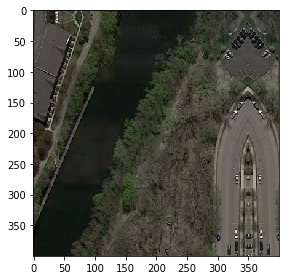

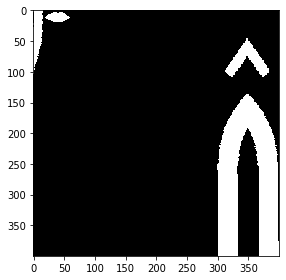

In [8]:
np.random.seed = SEED
if  not (os.path.isfile(COMPRESSED_IMG_LOCATION[COMPRESSED_IMG_TO_USE]) and USE_COMPRESS_IMG):
  print("[INFO]: Loading images into RAM", flush = True)
  X = np.zeros((len(IMAGES_FILENAMES), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  Y = np.zeros((len(IMAGES_FILENAMES), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

  for n, filename in tqdm(enumerate(IMAGES_FILENAMES), total=len(IMAGES_FILENAMES)):   
      img = imread(IMAGE_DATA_PATH + filename)[:,:,:IMG_CHANNELS]
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X[n] = img
      mask = imread(MASK_DATA_PATH + filename)
      mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                        preserve_range=True), axis=-1)
      if USE_GENERATED_IMG:
          Y[n] = mask[:,:,0]
      else:
          Y[n] = mask

  x_train=X 
  y_train=Y

  if input('[WARNING] : Do you want to save the X and Y to be able to reload faster? y/n') == 'y':
    np.savez_compressed(COMPRESSED_IMG_LOCATION[COMPRESSED_IMG_TO_USE] , X=X, Y=Y)
else:
  print('[INFO] : Loading images from saved numpy array.')
  loaded = loaded = np.load(COMPRESSED_IMG_LOCATION[COMPRESSED_IMG_TO_USE])
  x_train = X = loaded['X']
  y_train = Y = loaded['Y']
  if VERBOSE:
    print(f'[INFO] : Loaded {X.shape[0]} images')
    imshow(x_train[1])
    plt.show()
    imshow(np.squeeze(y_train[1]))

### Model Building

In [9]:
# Build U-Net++ model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH,+ IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)

# One DenseNet Node
d_u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
d1 = tf.keras.layers.concatenate([d_u1, c3])
d1 = tf.keras.layers.Dense(64, activation='relu')(d1)

u7 = tf.keras.layers.concatenate([u7, d1])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c7)

d_u2 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
d2 = tf.keras.layers.concatenate([d_u2, c2])
d2 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(d2)

d_u3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d1)
d3 = tf.keras.layers.concatenate([d_u3, d2, c2])
d3 = tf.keras.layers.Dense(128, activation=tf.keras.activations.relu)(d3)


u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, d3])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c8)


d_uc2 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c2)
d4 = tf.keras.layers.concatenate([d_uc2, c1])
d4 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(d4)

d_ud2 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(d2)
d5 = tf.keras.layers.concatenate([d_ud2, d4, c1])
d5 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(d5)

d_ud3 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(d3)
d6 = tf.keras.layers.concatenate([d_ud3, d5, c1])
d6 = tf.keras.layers.Dense(256, activation=tf.keras.activations.relu)(d6)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, d6], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.relu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

# Deep learning
#output_d4 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
#output_d5 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(d5)
#output_d6 = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(d6)


    
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])   
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_accuracy', 'categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 400, 400, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 400, 400, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

### Saved Model Loading

In [10]:
if USE_SAVED_MODEL:
    if not os.path.isfile(MODEL_SAVE_LOCATION):
        raise IOError("[ERROR]: Could not locate file for model weights. Proceding without loading weights.")
    else:
        model.load_weights(MODEL_SAVE_LOCATION)
        print("[INFO]: Loading saved model weights")

[INFO]: Loading saved model weights


### Checkpoints for Training

In [0]:
%load_ext tensorboard
#!rm -rf ./logs/ 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = [
  #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tensorboard_callback,
  cp_callback 
]
%tensorboard --logdir logs/fit

### Training

In [0]:
%%time
results = model.fit(X, [Y, Y, Y, Y], validation_split=0.1, batch_size=1, epochs=3, callbacks=callbacks, shuffle=True, initial_epoch=0)

In [0]:
#model.save_weights(MODEL_SAVE_LOCATION+".unet++supervised", overwrite=True)

In [0]:
 model.load_weights(MODEL_SAVE_LOCATION)

### Image Demo on Training Set

In [0]:
# Creating ouput for submission

foreground_threshold = 0.40 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(im):
    patch_size = 16
    mask = np.zeros((im.shape[1]//patch_size, im.shape[0]//patch_size))
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            mask[i//patch_size, j//patch_size] = patch_to_label(patch)
    return mask

1/1 [==============================] - 3s 3s/sample
(1, 400, 400, 1)
(400, 400)
- Original Image:


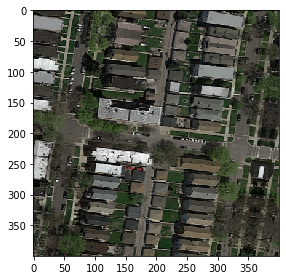

- Prediction:


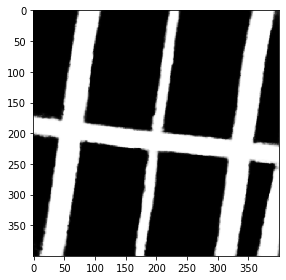

- Original Groundtruth:


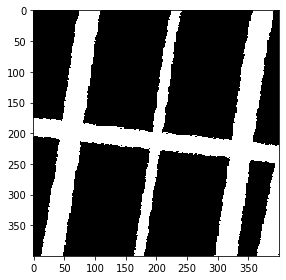

Prediction with mask 16x16


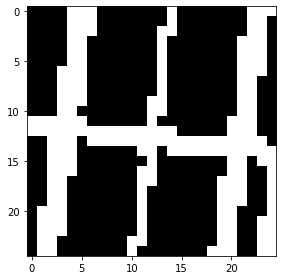

- Original Groundtruth 16x16:


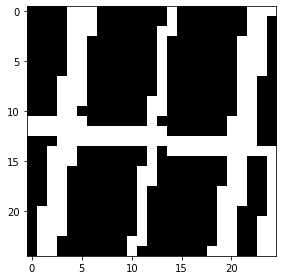

- Pixels different between prediction:
- Number of different pixels: 9.0


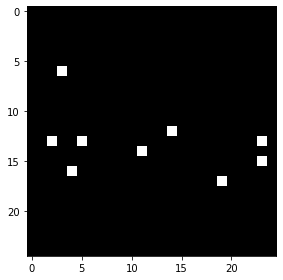

In [12]:
RENDER_SUBMISSION_MASK = True # this is a using pathches of 16x16

def get_prediction(img):
    x=np.array(img)
    x=np.expand_dims(x, axis=0)
    predict = model.predict(x, verbose=1)
    print(predict.shape)
    #predict = (predict > best_threshold).astype(np.uint8)
    #predict = predict /255
    ##predict = (predict - predict.min())/(predict.max() - predict.min())
    predict = np.squeeze(predict[0])
    print(predict.shape)

    return predict

idx = 20
prediction = get_prediction(x_train[idx])

print("- Original Image:")
imshow(x_train[idx])
plt.show()

print("- Prediction:")
imshow(prediction)
plt.show()

print("- Original Groundtruth:")
imshow(np.squeeze(y_train[idx]));
plt.show()

if RENDER_SUBMISSION_MASK:
  print('Prediction with mask 16x16')
  prediction = mask_to_submission_strings(prediction)
  imshow(prediction)
  plt.show()

  print('- Original Groundtruth 16x16:')
  imshow(mask_to_submission_strings(np.squeeze(y_train[idx])));
  plt.show()

  print('- Pixels different between prediction:')
  imshow(np.abs(prediction - mask_to_submission_strings(np.squeeze(y_train[idx]))))
  print(f'- Number of different pixels: {np.abs(prediction - mask_to_submission_strings(np.squeeze(y_train[idx]))).sum()}')


# best foreground_threshold: missclasified tiles count

100%|██████████| 7/7 [01:48<00:00, 15.63s/it]


best foreground_threshold value : 0.343
Given best threshold average number of missclasified tiles : 9.87
[INFO] : saved foreground_threshold data in file.


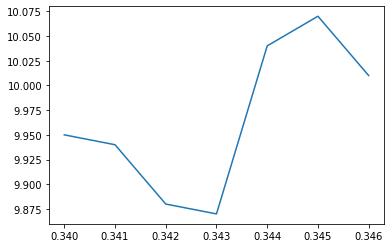

In [16]:
# best foreground_threshold: missclasified tiles count
NUMBERS_OF_IMAGES_TO_USE = 100      # This is the number of images to use durring the calculation.
MIN_FOREGROUND_VALUE = 0.34 #included
MAX_FOREGOURND_VALUE = 0.346   #included
STEP = 0.001

assert MIN_FOREGROUND_VALUE < MAX_FOREGOURND_VALUE , f'MIN_FOREGROUND_VALUE : {MIN_FOREGROUND_VALUE} must be smaller than MAX_FOREGOURND_VALUE : {MAX_FOREGOURND_VALUE}'

# assign a label to a patch
def patch_to_label(patch, fg):
    df = np.mean(patch)
    if df > fg:
        return 1
    else:
        return 0

def mask_to_submission_strings(im, fg):
    patch_size = 16
    mask = np.zeros((im.shape[1]//patch_size, im.shape[0]//patch_size))
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            mask[i//patch_size, j//patch_size] = patch_to_label(patch, fg)
    return mask

def get_prediction(img, fg):
    x=np.array(img)
    x=np.expand_dims(x, axis=0)
    predict = model.predict(x, verbose=0)[0]
    #predict = (predict > best_threshold).astype(np.uint8)
    #predict = predict /255
    predict = (predict - predict.min())/(predict.max() - predict.min())
    predict = np.squeeze(predict)
    
    return mask_to_submission_strings(predict, fg)


number_of_pixels_off = []  #average number of missclasified images
fg_values =  np.arange(MIN_FOREGROUND_VALUE,MAX_FOREGOURND_VALUE+STEP,STEP)
for idx, fg in tqdm(enumerate(fg_values), total= len(fg_values)):
  total = 0
  for idx in range(NUMBERS_OF_IMAGES_TO_USE):
    prediction = get_prediction(x_train[idx], fg)
    total += np.abs(prediction - mask_to_submission_strings(np.squeeze(y_train[idx]), fg)).sum()
    #print(total)
  number_of_pixels_off.append( total / NUMBERS_OF_IMAGES_TO_USE)
plt.plot(fg_values, number_of_pixels_off);
print(flush=True)
print( f'best foreground_threshold value : {fg_values[np.argmin(number_of_pixels_off)]}')
print(f'Given best threshold average number of missclasified tiles : {np.min(number_of_pixels_off)}')

# creating data file of values used
temp = zip(fg_values, number_of_pixels_off)
with open('threshold_search_data.dat', 'w') as f:
  f.write(f'NUMBERS_OF_IMAGES_TO_USE = {NUMBERS_OF_IMAGES_TO_USE}      # This is the number of images to use durring the calculation.\n \
MIN_FOREGROUND_VALUE = {MIN_FOREGROUND_VALUE} #included \n\
MAX_FOREGOURND_VALUE = {MAX_FOREGOURND_VALUE}  #included \n\
STEP = {STEP}\n')
  for t in temp:
    f.write(str(t)+'\n')
print('[INFO] : saved foreground_threshold data in file.')

In [17]:
# best foreground_threshold: f1 score


from sklearn.metrics import f1_score


def get_F1_threshold(x_val, y_val, threshold_value):
  '''
  let x_val be an array of length [100,400,400,3]. These are the images from the validation set
  let y_val be an array of shape [100,400,400,1]. These are the masks of the ground truth
  let threshold_value be the value of the threshold to test
  '''

  assert x_val.shape[0] >= 100 , "x_val is not large enough. First dimmension less than 100 needs to be greater than 100"
  assert y_val.shape[0] >= 100, "y_val is not large enough. First dimmension less than 100 needs to be greater than 100"
  
  NUMBERS_OF_IMAGES_TO_USE = 100      # This is the number of images to use durring the calculation.

  # assign a label to a patch
  def patch_to_label(patch, fg):
      df = np.mean(patch)
      if df > fg:
          return 1
      else:
          return 0

  def mask_to_submission_strings(im, fg):
      patch_size = 16
      mask = np.zeros((im.shape[1]//patch_size, im.shape[0]//patch_size))
      for j in range(0, im.shape[1], patch_size):
          for i in range(0, im.shape[0], patch_size):
              patch = im[i:i + patch_size, j:j + patch_size]
              mask[i//patch_size, j//patch_size] = patch_to_label(patch, fg)
      return mask

  def get_prediction(img, fg):
      x=np.array(img)
      x=np.expand_dims(x, axis=0)
      predict = model.predict(x, verbose=0)[0]
      #predict = (predict > best_threshold).astype(np.uint8)
      #predict = predict /255
      predict = (predict - predict.min())/(predict.max() - predict.min())
      predict = np.squeeze(predict)
      
      return mask_to_submission_strings(predict, fg)
    
  accumulator = 0
  for idx in tqdm(range(NUMBERS_OF_IMAGES_TO_USE), desc='Calculating F1 score'):
    prediction = get_prediction(x_val[idx], threshold_value)
    accumulator += f1_score(prediction.astype(np.bool).flatten(), mask_to_submission_strings(np.squeeze(y_val[idx]), threshold_value).astype(np.bool).flatten(), average='binary')
  print( f'\nf1 socre is : { accumulator / NUMBERS_OF_IMAGES_TO_USE}')

get_F1_threshold(x_train, y_train, 0.343)

Calculating F1 score: 100%|██████████| 100/100 [00:16<00:00,  6.27it/s]


f1 socre is : 0.9710235675090249


### Running Predictions on Test Set

In [0]:
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)
    return rimg

predictions = []
if RUN_PREDICTIONS_ON_TEST_IMAGES:
    print("[INFO]: Running prediction on submission set")
    if not os.path.isdir(PREDICTION_SUBMISSION_DIR):
        os.mkdir(PREDICTION_SUBMISSION_DIR)
    for i in range(1, 51):
        pimg = imread(SUBMISSION_DATA_DIR + f'test_{i}/' f"test_{i}.png")[:,:,:IMG_CHANNELS]
        predictions.append(predict_img_with_smooth_windowing(
            pimg,
            window_size=IMG_WIDTH,
            subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
            nb_classes=1,
                pred_func=(
                    lambda img_batch_subdiv: model.predict(img_batch_subdiv)
                )
            )
        )
else:
    print("[INFO]: Skipping predicting test images")

[INFO]: Running prediction on submission set


100%|██████████| 8/8 [00:18<00:00,  2.28s/it]


### Prediction Saving

In [0]:
imshow(np.squeeze(predictions[0].copy().astype(np.unit8)))

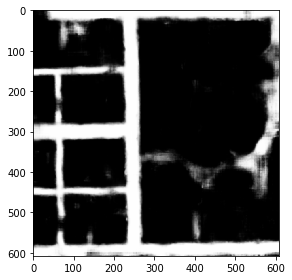

In [0]:
imshow(np.squeeze((predictions[2].copy()*255).astype(np.uint8)))

In [0]:
np.savez_compressed("prediction_UNet++_150" , prediction =predictions)

In [0]:
if RUN_PREDICTIONS_ON_TEST_IMAGES:
    print("[INFO]: Writing prediction to drive")

    ROAD_THRESHOLD = 0.25#0.1

    pred = np.array(predictions.copy())
    for i in range(1, 51):
        pimg = pred[i-1]
        w = pimg.shape[0]
        h = pimg.shape[1]
        cimg = np.zeros((w, h, 3), dtype=np.uint8)
        pimg *= 255
        pimg = pimg.astype(np.uint8)
        pimg8 = np.squeeze(img_float_to_uint8(pimg))
        cimg[:, :, 0] = pimg8
        cimg[:, :, 1] = pimg8
        cimg[:, :, 2] = pimg8
        Image.fromarray(cimg).save(PREDICTION_SUBMISSION_DIR + f"gt_{i}.png")
else:
    print("[INFO]: Skipping write of predictions to disk")

[INFO]: Writing prediction to drive


### AICrowd Submission Creation

In [0]:
# Creating ouput for submission

foreground_threshold = 0.41 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


time = strftime("%Y%m%dT%H%M%S")
submission_filename = f'submission-{time}.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = f'{PREDICTION_SUBMISSION_DIR}gt_{i}.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

## References

- https://androidkt.com/tensorflow-keras-unet-for-image-image-segmentation/

- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

- https://arxiv.org/pdf/1505.04597.pdf